Цель работы:
- получить навыки обучения нейронных сетей на небольшом наборе
данных, используя расширение набора данных путем применения функции аугментации.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Загрузка данных

In [3]:
INPUT_SHAPE = (224, 224, 3) # as in AlexNet
NUM_CLASSES = 2


In [4]:
INPUT_SHAPE[:2]

(224, 224)

In [5]:
import os
from tqdm import tqdm
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


def download_data(path_dataset, resize_len=INPUT_SHAPE[:2]):
    '''resize_len=224 as in AlexNet'''
    dataset = []
    datalabel = []

    for filename in tqdm(sorted(os.listdir(path=path_dataset))):
        img = Image.open(path_dataset + filename).resize(resize_len)
        img = np.array(img)

        if 'cat' in filename:
            label = 0
        else:
            label = 1

        dataset.append(img.astype(np.uint8))
        datalabel.append(label)

    return np.array(dataset), np.array(datalabel)

In [6]:
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/materials/Dogs-Cats/"

In [7]:
train_dataset, y_train = download_data(DATASET_PATH+'Train/')

100%|██████████| 2400/2400 [00:33<00:00, 72.47it/s] 


In [8]:
test_dataset, y_test = download_data(DATASET_PATH+'Test/')

100%|██████████| 1600/1600 [00:20<00:00, 79.77it/s] 


In [9]:
train_dataset.shape, y_train.shape, test_dataset.shape, y_test.shape

((2400, 224, 224, 3), (2400,), (1600, 224, 224, 3), (1600,))

In [10]:
import pandas as pd

display(pd.DataFrame(y_train).value_counts())
display(pd.DataFrame(y_test).value_counts())

,count
0,
0,1200
1,1200


,count
0,
0,800
1,800


In [11]:
def show_pic(dataset, i_end, i_start=0, figsize=(8, 8)):
    plt.figure(figsize=figsize)
    for j, i in enumerate(range(i_start, i_end)):
        plt.subplot(1, i_end-i_start, j+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(dataset[i])
    plt.show()

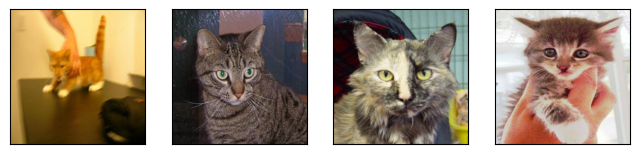

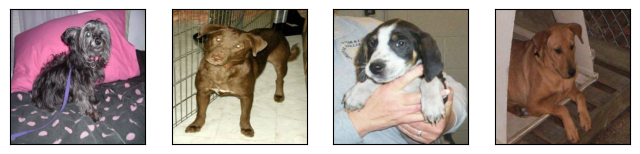

In [22]:
show_pic(train_dataset, 4)
show_pic(train_dataset, i_end=1204, i_start=1200)

# Реализация топологии нейронной сети

В качестве запоминания и большего понимания реализую AlexNet

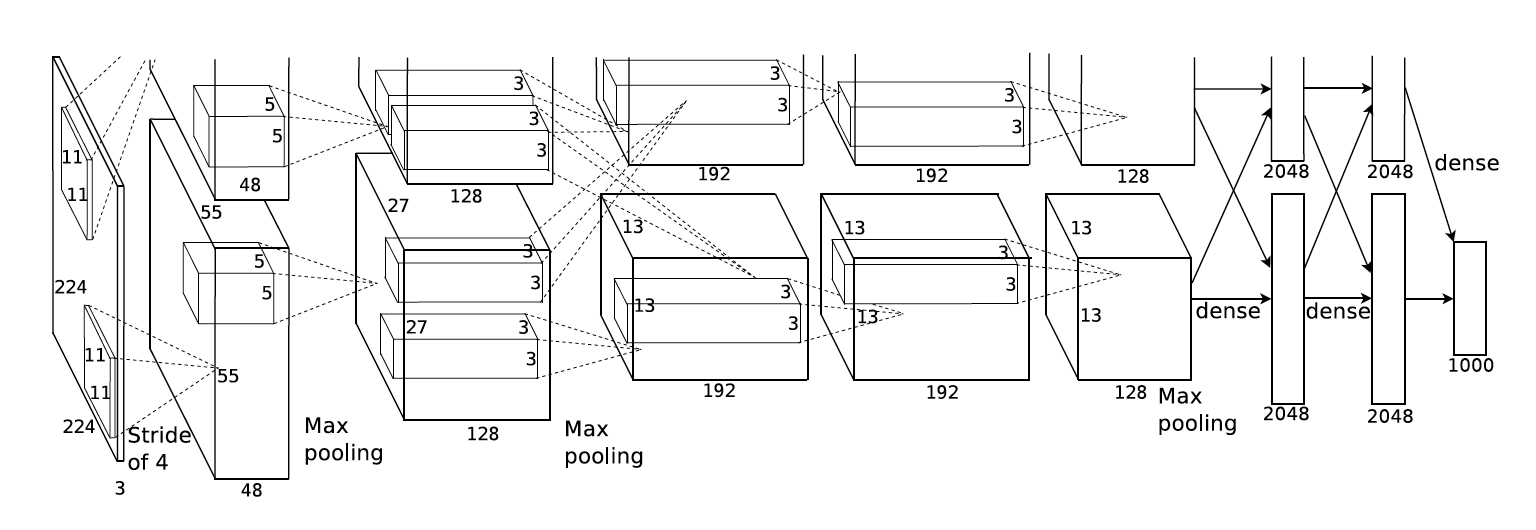

output_calc = ((H+2*padding−kernel)/stride)+1


| Layer | Type                                  | Params                    | Output calc              | Output Shape               |
| ----- | ------------------------------------- | ------------------------- | ------------------------ | -------------------------- |
| Input | -                                     | -                         | -                        | 3@224×224                  |
| Conv1 | 96×(11×11), stride=4, pad=2(or equiv) | 96×11×11×3                | ((224+2*2-11)/4)+1 = 55  | 96@55×55   |
| Pool1 | 3×3, stride=2, pad=0                  | -                         | ((55+2*0-3)/2)+1 = 27    | 96@27×27   |
| Conv2 | 256×(5×5), stride=1, pad=2            | 256×5×5×96                | ((27+2*2-5)/1)+1 = 27    | 256@27×27  |
| Pool2 | 3×3, stride=2, pad=0                  | -                         | ((27+2*0-3)/2)+1 = 13    | 256@13×13  |
| Conv3 | 384×(3×3), stride=1, pad=1            | 384×3×3×256               | ((13+2*1-3)/1)+1 = 13    | 384@13×13  |
| Conv4 | 384×(3×3), stride=1, pad=1            | 384×3×3×384               | ((13+2*1-3)/1)+1 = 13    | 384@13×13  |
| Conv5 | 256×(3×3), stride=1, pad=1            | 256×3×3×384               | ((13+2*1-3)/1)+1 = 13    | 256@13×13  |
| Pool3 | 3×3, stride=2, pad=0                  | -                         | ((13+2*0-3)/2)+1 = 6     | 256@6×6    |
| FC6   | Flatten + Dense                       | 256×6×6=9216  → 4096      | -                        | 4096   |
| FC7   | Dense                                 | 4096 → 4096               | -                        | 4096   |
| FC8   | Dense                                 | 4096 → 1000 (num classes) | -                        | 1000    |

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.AdaptiveMaxPool2d((6, 6))  # Force 256x6x6 regardless of input_shape
        )

        self.classifier = nn.Sequential(
            nn.Linear((256*6*6), 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        out = self.feature_extractor(x)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out


In [13]:
# Model example

model = AlexNet()
x = torch.randn(32, 3, 224, 224)  # Batch of 32 images
output = model(x)
print(output.shape)
output[0]

torch.Size([32, 2])


tensor([0.0014, 0.0002], grad_fn=<SelectBackward0>)

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader


train_tensor = torch.tensor(
    train_dataset / 255.0, # normalize data [0, 1]
    dtype=torch.float32
).permute(0, 3, 1, 2) # (N, H, W, C) → (N, C, H, W)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)#.unsqueeze(1)

test_tensor = torch.tensor(
    test_dataset / 255.0, # normalize data [0, 1]
    dtype=torch.float32
).permute(0, 3, 1, 2) # (N, H, W, C) → (N, C, H, W)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)#.unsqueeze(1)


train_tensor_dataset = TensorDataset(train_tensor, y_train_tensor)
test_tensor_dataset = TensorDataset(test_tensor, y_test_tensor)

# Обучение и тестирование нейронной сети

In [15]:
LEARNING_RATE = 0.0001
NUM_EPOCHS = 31
BATCH_SIZE = 32
TO_DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TO_DEVICE

'cuda'

In [ ]:
import torch.optim as optim

train_loader = DataLoader(
    train_tensor_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_loader = DataLoader(test_tensor_dataset, batch_size=BATCH_SIZE)

device = torch.device(TO_DEVICE)

model = AlexNet()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

In [16]:
def train_val(train_loader, test_loader, device, model, criterion, optimizer):
    train_losses = []
    val_losses = []

    train_accs = []
    val_accs = []

    for epoch in range(NUM_EPOCHS):
        # ~~~> 1. Learning epoch
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Training", unit="batch")
        for batch_idx, (imgs, labels) in enumerate(train_loader_tqdm):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            # Calculate online average loss and accuracy
            current_batch = batch_idx + 1
            avg_loss = running_loss / current_batch
            avg_acc = correct_train / total_train if total_train > 0 else 0.0

            train_loader_tqdm.set_postfix(
                loss=f"{avg_loss:.4f}",
                acc=f"{avg_acc:.4f}"
            )

        # Avg val epoch loss
        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        # ~~~> 2. Validation epoch
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)

                outputs = model(imgs)

                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = outputs.argmax(dim=1).float()
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        # Avg val epoch loss
        val_loss /= len(test_loader)
        val_acc = correct_val / total_val

        # ~~~> 3. Save epoxh metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(
            f"Epoch [{epoch+1}/{NUM_EPOCHS}]:"
            f"\n\t- train loss: {train_loss:.4f}"
            f"\n\t- train acc: {train_acc:.4f} "
            f"\n\t- val loss: {val_loss:.4f}"
            f"\n\t- val acc: {val_acc:.4f}"
        )

    return train_losses, val_losses, train_accs, val_accs

In [41]:
train_losses, val_losses, train_accs, val_accs = train_val(train_loader, test_loader, device, model, criterion, optimizer)


Epoch 1/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.30batch/s, acc=0.5967, loss=0.6695]


Epoch [1/31]:
	- train loss: 0.6695
	- train acc: 0.5967 
	- val loss: 0.6366
	- val acc: 0.6506


Epoch 2/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.22batch/s, acc=0.6354, loss=0.6450]


Epoch [2/31]:
	- train loss: 0.6450
	- train acc: 0.6354 
	- val loss: 0.6625
	- val acc: 0.6350


Epoch 3/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.59batch/s, acc=0.6608, loss=0.6169]


Epoch [3/31]:
	- train loss: 0.6169
	- train acc: 0.6608 
	- val loss: 0.6029
	- val acc: 0.6787


Epoch 4/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.05batch/s, acc=0.7004, loss=0.5770]


Epoch [4/31]:
	- train loss: 0.5770
	- train acc: 0.7004 
	- val loss: 0.6154
	- val acc: 0.6606


Epoch 5/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.46batch/s, acc=0.7262, loss=0.5413]


Epoch [5/31]:
	- train loss: 0.5413
	- train acc: 0.7262 
	- val loss: 0.5517
	- val acc: 0.7244


Epoch 6/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.42batch/s, acc=0.7562, loss=0.5045]


Epoch [6/31]:
	- train loss: 0.5045
	- train acc: 0.7562 
	- val loss: 0.5641
	- val acc: 0.7175


Epoch 7/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.05batch/s, acc=0.7929, loss=0.4427]


Epoch [7/31]:
	- train loss: 0.4427
	- train acc: 0.7929 
	- val loss: 0.5382
	- val acc: 0.7319


Epoch 8/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.08batch/s, acc=0.8271, loss=0.3915]


Epoch [8/31]:
	- train loss: 0.3915
	- train acc: 0.8271 
	- val loss: 0.5289
	- val acc: 0.7481


Epoch 9/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 16.85batch/s, acc=0.8488, loss=0.3445]


Epoch [9/31]:
	- train loss: 0.3445
	- train acc: 0.8488 
	- val loss: 0.5803
	- val acc: 0.7206


Epoch 10/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.35batch/s, acc=0.8733, loss=0.3096]


Epoch [10/31]:
	- train loss: 0.3096
	- train acc: 0.8733 
	- val loss: 0.5813
	- val acc: 0.7538


Epoch 11/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.03batch/s, acc=0.9071, loss=0.2243]


Epoch [11/31]:
	- train loss: 0.2243
	- train acc: 0.9071 
	- val loss: 0.6231
	- val acc: 0.7488


Epoch 12/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.39batch/s, acc=0.9375, loss=0.1723]


Epoch [12/31]:
	- train loss: 0.1723
	- train acc: 0.9375 
	- val loss: 0.6279
	- val acc: 0.7700


Epoch 13/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.44batch/s, acc=0.9383, loss=0.1519]


Epoch [13/31]:
	- train loss: 0.1519
	- train acc: 0.9383 
	- val loss: 0.6153
	- val acc: 0.7712


Epoch 14/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 16.77batch/s, acc=0.9408, loss=0.1920]


Epoch [14/31]:
	- train loss: 0.1920
	- train acc: 0.9408 
	- val loss: 0.5604
	- val acc: 0.7806


Epoch 15/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.42batch/s, acc=0.9675, loss=0.0899]


Epoch [15/31]:
	- train loss: 0.0899
	- train acc: 0.9675 
	- val loss: 0.7286
	- val acc: 0.7706


Epoch 16/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 16.91batch/s, acc=0.9625, loss=0.1140]


Epoch [16/31]:
	- train loss: 0.1140
	- train acc: 0.9625 
	- val loss: 0.7613
	- val acc: 0.7719


Epoch 17/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.14batch/s, acc=0.9679, loss=0.0874]


Epoch [17/31]:
	- train loss: 0.0874
	- train acc: 0.9679 
	- val loss: 0.7908
	- val acc: 0.7600


Epoch 18/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.21batch/s, acc=0.9871, loss=0.0424]


Epoch [18/31]:
	- train loss: 0.0424
	- train acc: 0.9871 
	- val loss: 0.9870
	- val acc: 0.7644


Epoch 19/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 16.91batch/s, acc=0.9554, loss=0.1310]


Epoch [19/31]:
	- train loss: 0.1310
	- train acc: 0.9554 
	- val loss: 0.8153
	- val acc: 0.7881


Epoch 20/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.19batch/s, acc=0.9675, loss=0.0815]


Epoch [20/31]:
	- train loss: 0.0815
	- train acc: 0.9675 
	- val loss: 0.7168
	- val acc: 0.7362


Epoch 21/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 16.78batch/s, acc=0.9804, loss=0.0700]


Epoch [21/31]:
	- train loss: 0.0700
	- train acc: 0.9804 
	- val loss: 0.6519
	- val acc: 0.7688


Epoch 22/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.29batch/s, acc=0.9912, loss=0.0286]


Epoch [22/31]:
	- train loss: 0.0286
	- train acc: 0.9912 
	- val loss: 1.0280
	- val acc: 0.7675


Epoch 23/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.17batch/s, acc=0.9663, loss=0.1237]


Epoch [23/31]:
	- train loss: 0.1237
	- train acc: 0.9663 
	- val loss: 0.8628
	- val acc: 0.7812


Epoch 24/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.13batch/s, acc=0.9908, loss=0.0364]


Epoch [24/31]:
	- train loss: 0.0364
	- train acc: 0.9908 
	- val loss: 0.9145
	- val acc: 0.7925


Epoch 25/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.30batch/s, acc=0.9967, loss=0.0138]


Epoch [25/31]:
	- train loss: 0.0138
	- train acc: 0.9967 
	- val loss: 2.6678
	- val acc: 0.6000


Epoch 26/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 16.63batch/s, acc=0.9533, loss=0.1356]


Epoch [26/31]:
	- train loss: 0.1356
	- train acc: 0.9533 
	- val loss: 1.0987
	- val acc: 0.7556


Epoch 27/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.30batch/s, acc=0.9954, loss=0.0171]


Epoch [27/31]:
	- train loss: 0.0171
	- train acc: 0.9954 
	- val loss: 1.0356
	- val acc: 0.7756


Epoch 28/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 16.95batch/s, acc=0.9742, loss=0.0789]


Epoch [28/31]:
	- train loss: 0.0789
	- train acc: 0.9742 
	- val loss: 0.8934
	- val acc: 0.7675


Epoch 29/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.32batch/s, acc=0.9796, loss=0.0620]


Epoch [29/31]:
	- train loss: 0.0620
	- train acc: 0.9796 
	- val loss: 0.8239
	- val acc: 0.7731


Epoch 30/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 17.32batch/s, acc=0.9975, loss=0.0092]


Epoch [30/31]:
	- train loss: 0.0092
	- train acc: 0.9975 
	- val loss: 1.0640
	- val acc: 0.7913


Epoch 31/31 - Training: 100%|██████████| 75/75 [00:04<00:00, 16.80batch/s, acc=1.0000, loss=0.0005]


Epoch [31/31]:
	- train loss: 0.0005
	- train acc: 1.0000 
	- val loss: 1.2896
	- val acc: 0.7925


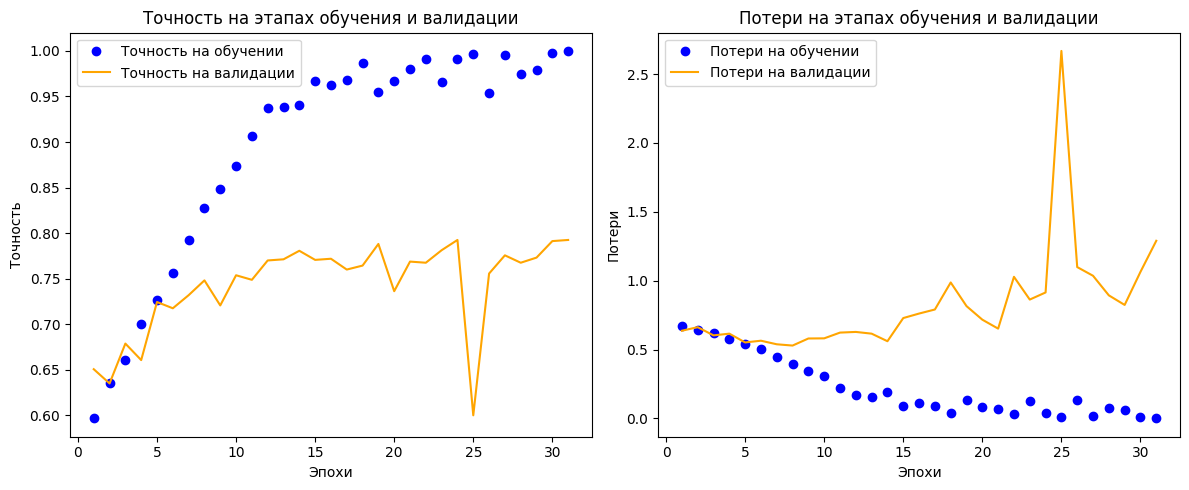

In [47]:
import matplotlib.pyplot as plt

epochs = range(1, NUM_EPOCHS + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # One figure, two axes

# Accuracy plot
ax1.plot(epochs, train_accs, "bo", label="Точность на обучении")
ax1.plot(epochs, val_accs, color="orange", label="Точность на валидации")
ax1.set_title("Точность на этапах обучения и валидации")
ax1.set_xlabel("Эпохи")
ax1.set_ylabel("Точность")
ax1.legend()

# Loss plot
ax2.plot(epochs, train_losses, "bo", label="Потери на обучении")
ax2.plot(epochs, val_losses, color="orange", label="Потери на валидации")
ax2.set_title("Потери на этапах обучения и валидации")
ax2.set_xlabel("Эпохи")
ax2.set_ylabel("Потери")
ax2.legend()

plt.tight_layout()  # Better spacing
plt.show()


При обучении нейронной сети точность достигла 98%. При валидации точность достигла
всего 73%. Это говорит о переобучении сети.
Первоначальные веса нейронной сети инициализируются случайными числами. Поскольку у нас относительно немного обучающих образцов, переобучение становится
проблемой номер один.

# Аугментация данных

Прием обогащения данных реализует подход создания дополнительных
обучающих данных из имеющихся путем трансформации образцов множеством случайных
преобразований, дающих правдоподобные изображения. Цель состоит в том, чтобы на этапе
обучения модель никогда не увидела одно и то же изображение дважды. Это поможет
модели выявить больше особенностей данных и достичь лучшей степени обобщения.

In [19]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.ToPILImage(), # нужно, если вход — numpy-изображение
    transforms.RandomHorizontalFlip(p=0.5), # Аналог RandomFlip
    transforms.RandomRotation(degrees=36), # Аналог RandomRotation(0.1)
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)), # Аналог RandomZoom(0.2)
    transforms.Resize(INPUT_SHAPE[:2]), # Обязательно
    transforms.ToTensor()
])

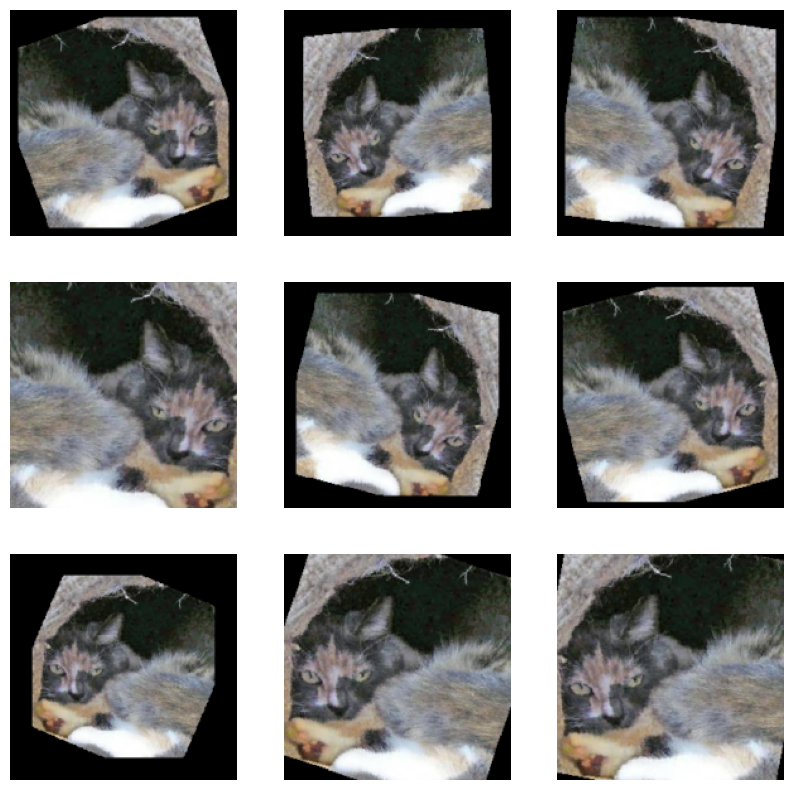

In [28]:
import matplotlib.pyplot as plt
import torch

# Берём 7-е изображение из массива NumPy (формат HWC, uint8)
image_np = train_dataset[7]
plt.figure(figsize=(10, 10))
for i in range(9):
    # Применяем аугментацию к NumPy-изображению (HWC, uint8)
    augmented_image = train_transforms(image_np)
    # augmented_image — tensor CxHxW в диапазоне [0,1]
    # Переводим в формат HWC для plt.imshow
    img_to_show = augmented_image.permute(1, 2, 0).numpy()
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_to_show)
    plt.axis("off")
plt.show()

In [17]:
import torch
from torch.utils.data import Dataset


class AugmentedOnceDataset(Dataset):
    def __init__(self, images, labels=None, augment_transform=None):
        self.original_images = torch.tensor(
            images / 255.0, dtype=torch.float32
        ).permute(0, 3, 1, 2)    # (N, H, W, C) → (N, C, H, W)

        self.labels = (
            torch.tensor(labels, dtype=torch.long)
            if labels is not None
            else None
        )

        self.augment_transform = augment_transform

        # Generate augmentations
        if augment_transform is not None:
            augmented = []
            for img in self.original_images:
                aug_img = augment_transform(img)
                augmented.append(aug_img)

            self.augmented_images = torch.stack(augmented)
        else:
            self.augmented_images = None

        # To one dataset
        if self.augmented_images is not None:
            self.original_images = torch.cat(
                [self.original_images, self.augmented_images],
                dim=0
            )
            if self.labels is not None:
                self.labels = torch.cat(
                    [self.labels, self.labels],
                    dim=0
                )

    def __len__(self):
        return len(self.original_images)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.original_images[idx], self.labels[idx]
        return self.original_images[idx]


In [20]:
train_tensor_dataset = AugmentedOnceDataset(
    train_dataset, y_train,
    augment_transform=train_transforms
)

test_tensor_dataset = AugmentedOnceDataset(
    test_dataset, y_test, augment_transform=None
)

In [21]:
len(train_tensor_dataset), len(test_tensor_dataset), len(train_dataset), len(test_dataset)

(4800, 1600, 2400, 1600)

# Обучение и тестирование нейронной сети с использованием аугментации

In [23]:
import torch.optim as optim

train_loader = DataLoader(
    train_tensor_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_loader = DataLoader(test_tensor_dataset, batch_size=BATCH_SIZE)

device = torch.device(TO_DEVICE)

model = AlexNet()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

In [24]:
train_losses, val_losses, train_accs, val_accs = train_val(
    train_loader, test_loader, device, model, criterion, optimizer
)

Epoch 1/31 - Training: 100%|██████████| 150/150 [00:09<00:00, 15.35batch/s, acc=0.5492, loss=0.7162]


Epoch [1/31]:
	- train loss: 0.7162
	- train acc: 0.5492 
	- val loss: 0.6904
	- val acc: 0.5487


Epoch 2/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 18.37batch/s, acc=0.5756, loss=0.6832]


Epoch [2/31]:
	- train loss: 0.6832
	- train acc: 0.5756 
	- val loss: 0.6676
	- val acc: 0.6169


Epoch 3/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 18.07batch/s, acc=0.6298, loss=0.6527]


Epoch [3/31]:
	- train loss: 0.6527
	- train acc: 0.6298 
	- val loss: 0.6372
	- val acc: 0.6181


Epoch 4/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 18.02batch/s, acc=0.6671, loss=0.6053]


Epoch [4/31]:
	- train loss: 0.6053
	- train acc: 0.6671 
	- val loss: 0.6434
	- val acc: 0.6238


Epoch 5/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 18.18batch/s, acc=0.7100, loss=0.5602]


Epoch [5/31]:
	- train loss: 0.5602
	- train acc: 0.7100 
	- val loss: 0.5936
	- val acc: 0.6881


Epoch 6/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 18.04batch/s, acc=0.7469, loss=0.5121]


Epoch [6/31]:
	- train loss: 0.5121
	- train acc: 0.7469 
	- val loss: 0.6230
	- val acc: 0.7013


Epoch 7/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.94batch/s, acc=0.7848, loss=0.4595]


Epoch [7/31]:
	- train loss: 0.4595
	- train acc: 0.7848 
	- val loss: 0.5577
	- val acc: 0.7281


Epoch 8/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.88batch/s, acc=0.8142, loss=0.4173]


Epoch [8/31]:
	- train loss: 0.4173
	- train acc: 0.8142 
	- val loss: 0.5701
	- val acc: 0.7150


Epoch 9/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 18.02batch/s, acc=0.8415, loss=0.3682]


Epoch [9/31]:
	- train loss: 0.3682
	- train acc: 0.8415 
	- val loss: 0.5290
	- val acc: 0.7544


Epoch 10/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.74batch/s, acc=0.8681, loss=0.3181]


Epoch [10/31]:
	- train loss: 0.3181
	- train acc: 0.8681 
	- val loss: 0.5429
	- val acc: 0.7512


Epoch 11/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.79batch/s, acc=0.8915, loss=0.2701]


Epoch [11/31]:
	- train loss: 0.2701
	- train acc: 0.8915 
	- val loss: 0.5752
	- val acc: 0.7594


Epoch 12/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.89batch/s, acc=0.9040, loss=0.2232]


Epoch [12/31]:
	- train loss: 0.2232
	- train acc: 0.9040 
	- val loss: 0.6937
	- val acc: 0.7638


Epoch 13/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.68batch/s, acc=0.9290, loss=0.1799]


Epoch [13/31]:
	- train loss: 0.1799
	- train acc: 0.9290 
	- val loss: 0.6487
	- val acc: 0.7594


Epoch 14/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.49batch/s, acc=0.9433, loss=0.1460]


Epoch [14/31]:
	- train loss: 0.1460
	- train acc: 0.9433 
	- val loss: 0.6440
	- val acc: 0.7606


Epoch 15/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.66batch/s, acc=0.9540, loss=0.1225]


Epoch [15/31]:
	- train loss: 0.1225
	- train acc: 0.9540 
	- val loss: 0.8213
	- val acc: 0.7719


Epoch 16/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.74batch/s, acc=0.9490, loss=0.1695]


Epoch [16/31]:
	- train loss: 0.1695
	- train acc: 0.9490 
	- val loss: 0.7767
	- val acc: 0.7875


Epoch 17/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.62batch/s, acc=0.9729, loss=0.0775]


Epoch [17/31]:
	- train loss: 0.0775
	- train acc: 0.9729 
	- val loss: 0.8648
	- val acc: 0.7656


Epoch 18/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.53batch/s, acc=0.9729, loss=0.0805]


Epoch [18/31]:
	- train loss: 0.0805
	- train acc: 0.9729 
	- val loss: 0.7358
	- val acc: 0.7944


Epoch 19/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.47batch/s, acc=0.9723, loss=0.0810]


Epoch [19/31]:
	- train loss: 0.0810
	- train acc: 0.9723 
	- val loss: 0.7895
	- val acc: 0.7825


Epoch 20/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.57batch/s, acc=0.9779, loss=0.0651]


Epoch [20/31]:
	- train loss: 0.0651
	- train acc: 0.9779 
	- val loss: 0.7943
	- val acc: 0.7850


Epoch 21/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.45batch/s, acc=0.9773, loss=0.0640]


Epoch [21/31]:
	- train loss: 0.0640
	- train acc: 0.9773 
	- val loss: 0.9382
	- val acc: 0.7994


Epoch 22/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.30batch/s, acc=0.9788, loss=0.0581]


Epoch [22/31]:
	- train loss: 0.0581
	- train acc: 0.9788 
	- val loss: 0.9682
	- val acc: 0.7669


Epoch 23/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.51batch/s, acc=0.9777, loss=0.0636]


Epoch [23/31]:
	- train loss: 0.0636
	- train acc: 0.9777 
	- val loss: 0.9813
	- val acc: 0.7712


Epoch 24/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.47batch/s, acc=0.9760, loss=0.0733]


Epoch [24/31]:
	- train loss: 0.0733
	- train acc: 0.9760 
	- val loss: 0.9166
	- val acc: 0.7856


Epoch 25/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.41batch/s, acc=0.9902, loss=0.0350]


Epoch [25/31]:
	- train loss: 0.0350
	- train acc: 0.9902 
	- val loss: 1.0859
	- val acc: 0.7975


Epoch 26/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.29batch/s, acc=0.9767, loss=0.0645]


Epoch [26/31]:
	- train loss: 0.0645
	- train acc: 0.9767 
	- val loss: 0.7995
	- val acc: 0.7931


Epoch 27/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.45batch/s, acc=0.9852, loss=0.0484]


Epoch [27/31]:
	- train loss: 0.0484
	- train acc: 0.9852 
	- val loss: 0.8786
	- val acc: 0.7969


Epoch 28/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.46batch/s, acc=0.9831, loss=0.0523]


Epoch [28/31]:
	- train loss: 0.0523
	- train acc: 0.9831 
	- val loss: 0.8971
	- val acc: 0.7981


Epoch 29/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.15batch/s, acc=0.9877, loss=0.0411]


Epoch [29/31]:
	- train loss: 0.0411
	- train acc: 0.9877 
	- val loss: 1.2177
	- val acc: 0.7869


Epoch 30/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.34batch/s, acc=0.9746, loss=0.0771]


Epoch [30/31]:
	- train loss: 0.0771
	- train acc: 0.9746 
	- val loss: 0.8857
	- val acc: 0.7850


Epoch 31/31 - Training: 100%|██████████| 150/150 [00:08<00:00, 17.52batch/s, acc=0.9888, loss=0.0338]


Epoch [31/31]:
	- train loss: 0.0338
	- train acc: 0.9888 
	- val loss: 0.9827
	- val acc: 0.7850


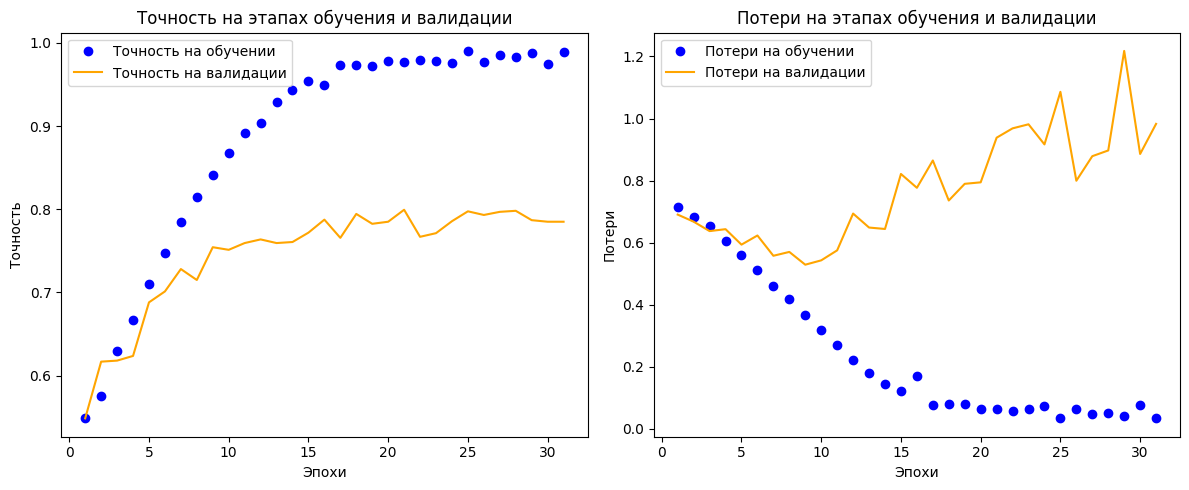

In [25]:
import matplotlib.pyplot as plt

epochs = range(1, NUM_EPOCHS + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # One figure, two axes

# Accuracy plot
ax1.plot(epochs, train_accs, "bo", label="Точность на обучении")
ax1.plot(epochs, val_accs, color="orange", label="Точность на валидации")
ax1.set_title("Точность на этапах обучения и валидации")
ax1.set_xlabel("Эпохи")
ax1.set_ylabel("Точность")
ax1.legend()

# Loss plot
ax2.plot(epochs, train_losses, "bo", label="Потери на обучении")
ax2.plot(epochs, val_losses, color="orange", label="Потери на валидации")
ax2.set_title("Потери на этапах обучения и валидации")
ax2.set_xlabel("Эпохи")
ax2.set_ylabel("Потери")
ax2.legend()

plt.tight_layout()  # Better spacing
plt.show()


# Вывод

В рамках экспериманта я таже попробовала обучаться только на аугментированых фото. Общий вывод в том, что аугментация положительно вляет на скор и лосс - переобучение модели снижается. Используя дополнительные методы регуляризации и настраивая параметры сети (например, число фильтров в сверточном слое, или число слоев в сети), можно добиться еще более высокой точности и стабильности обучения.

| Method | Result |
| ------------------- | ------------------- |  
| Before augmentation | 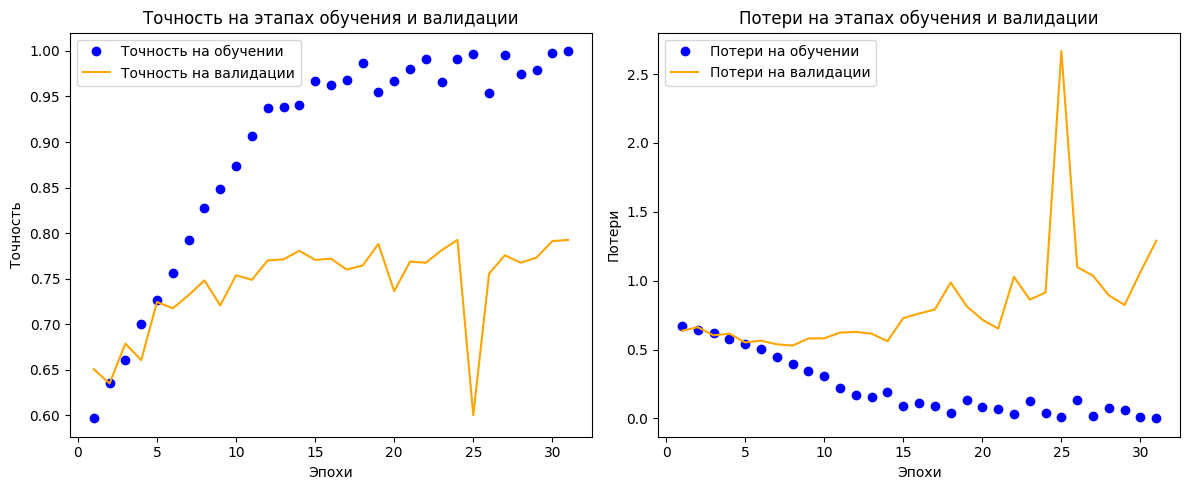 | 
| Just augmentation | 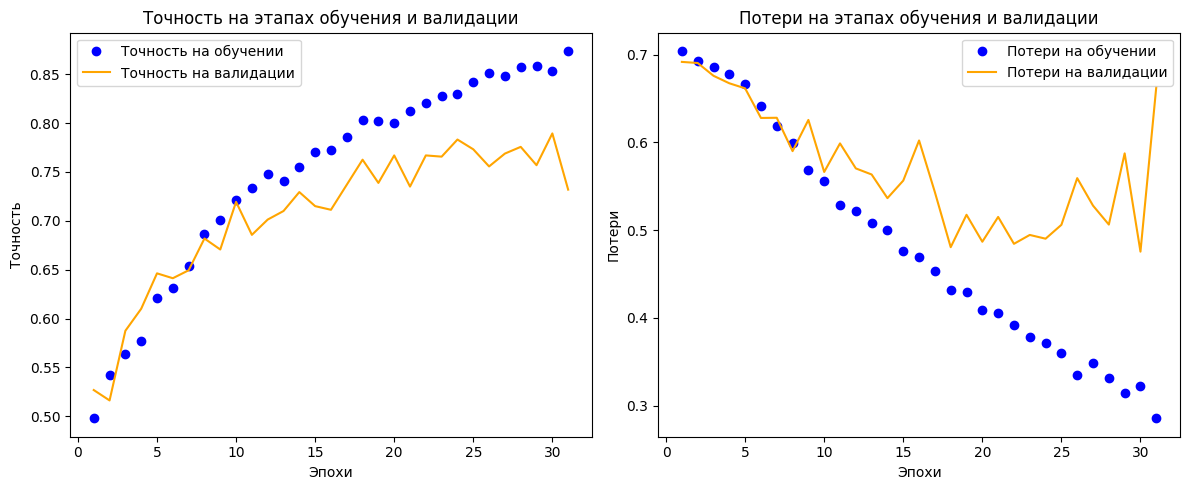 | 
| Aug + orig | 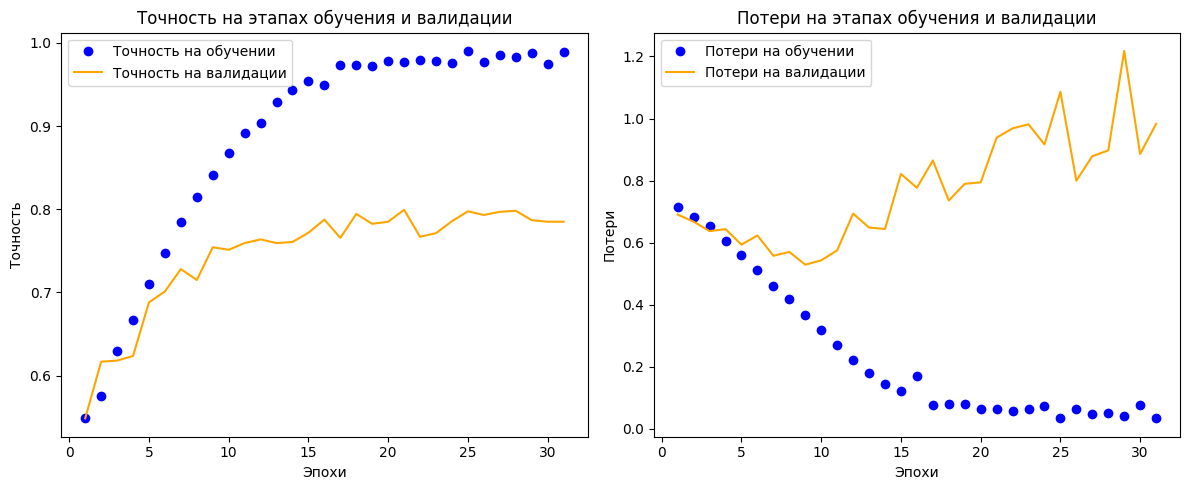 |